In [2]:
# Проверка среды выполнения СoLab/Local
oncolab = 'google.colab' in str(get_ipython())
if oncolab:
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


In [3]:
!pip install uproot3 awkward particle scikit-learn 'iminuit<2' probfit cupy-cuda110
!pip install gputil psutil humanize

     |████████████████████████████████| 122kB 6.9MB/s 
     |████████████████████████████████| 7.7MB 7.3MB/s 
     |████████████████████████████████| 215kB 48.7MB/s 
     |████████████████████████████████| 4.1MB 50.7MB/s 
     |████████████████████████████████| 1.8MB 33.2MB/s 
     |████████████████████████████████| 165.3MB 88kB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=e2afbf2b51e136309a812c2fb0729a7ea5b2f523072c58071bc0946c9d091617
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [4]:
# memory footprint support libraries/code
import os, psutil, humanize
import GPUtil as GPU
def printrss():
  process = psutil.Process(os.getpid())
  !cat /proc/cpuinfo | fgrep "model name" | sed -r "s/^model name\s+:\s+(.+)/\1/"
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  !df
  try:
    GPUs = GPU.getGPUs()
    gpu = GPUs[0]
    print("GPU", gpu.name, "| driver", gpu.driver)
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  except:
    print("No GPU provided")
    gpu = None
  return gpu

gpu = printrss()

Intel(R) Xeon(R) CPU @ 2.00GHz
Intel(R) Xeon(R) CPU @ 2.00GHz
Gen RAM Free: 12.8 GB  | Proc size: 128.8 MB
Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        113008892 40742308  72250200  37% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6666784        0   6666784   0% /sys/fs/cgroup
shm              6160384        0   6160384   0% /dev/shm
tmpfs            6666784       24   6666760   1% /var/colab
/dev/sda1      119512108 42019208  77476516  36% /etc/hosts
tmpfs            6666784        0   6666784   0% /proc/acpi
tmpfs            6666784        0   6666784   0% /proc/scsi
tmpfs            6666784        0   6666784   0% /sys/firmware
No GPU provided


In [ ]:
speedOfLight_mmperns = 299.792458 # мм/нс

In [ ]:
#@title Настройка выполнения кода
mode = "beta" #@param ["beta", "class"]

verbose = True #@param {type:"boolean"}

updateHDF = False #@param {type:"boolean"}

updateNNdata = True #@param {type:"boolean"}

useCuPy = True #@param {type:"boolean"}

# отключение использования CuPy, если GPU не выделен
if gpu is None:
  useCuPy = False

# Частота темновых шумов на 1 кв. мм. Если noisefreqpersqmm==0, то шум не моделируется.
noisefreqpersqmm =  50000#@param {type:"number"}

In [ ]:
#@title Настройка модели нейросети
restoreModel = False #@param {type:"boolean"}

fitModel = False #@param {type:"boolean"}

maxepochs = 300 #@param {type:"integer"}

batchSize = 1024 #@param {type:"integer"}

# конфигурация скрытых слоев нейросети
hlayers = (200, 100, 50, 20)


In [ ]:
import glob
if oncolab:
  from google.colab import drive 
  drive.mount('/mntDrive')  # смонтировать диск в папке «mntDrive»   
  datadir = '/mntDrive/My Drive/FARICH/Reconstruction/NN/data'
else:
  datadirs = [r'C:\Users\skono\Google Диск (skononov@nsu.ru)\FARICH\Reconstruction\NN\data', \
              r'D:\skono\Google Диск НГУ\FARICH\Reconstruction\NN\data', \
              r'C:\Users\skono\Google Диск НГУ\FARICH\Reconstruction\NN\data']
  datadir = None
  for dir in datadirs:
    if os.access(dir, os.R_OK):
      datadir = dir
      os.chdir(datadir)
      break

betatrain_filenames = [os.path.join(datadir, 'pi-pi-', 'rndm', fn) for fn in ['farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root', 'farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root']]
#betatrain_filenames = [os.path.join(datadir, 'pi-pi-', 'rndm', fn) for fn in ['farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root']]
class_filenames = [os.path.join(datadir, 'mu-pi-', 'rndm', 'farichsim_mu-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root'),]

rootFilenameMap = {'beta': betatrain_filenames, 'class': class_filenames}

Mounted at /mntDrive


In [ ]:
import sys
srcdir = os.path.dirname(datadir)
if srcdir not in sys.path:
  sys.path.append(srcdir)
from farichnnlib_v2 import *

In [ ]:
strategy = initcompstrategy(oncolab)

Could not set TPU distribution strategy!
Please provide a TPU Name to connect to.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Physical devices cannot be modified after being initialized
2 physical devices: /physical_device:CPU:0 /physical_device:GPU:0
1 physical GPUs: /physical_device:GPU:0
0 physical TPUs: 
2 logical devices: /device:CPU:0 /device:GPU:0
1 logical GPUs: /device:GPU:0
0 logical TPUs: 


In [ ]:
show_uproot_tree(uproot.open(rootFilenameMap[mode][0]))

TFile: ./farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root
  TTree: info_sim
    info_gen    /m_num_events
                 m_z_dis
    info_rad    /m_layers    /m_layers.first
                              m_layers.second
    info_pmt    /m_name
                 m_num_side_x
                 m_num_side_y
                 m_gap
                 m_size
                 m_chip_num_size
                 m_chip_pitch
                 m_chip_size
                 m_chip_offset
                 m_focal_length
                 m_trg_window
                 m_origin_pos/m_origin_pos._2
                              m_origin_pos._1
                              m_origin_pos._0
  TTree: raw_data
    event       /m_id_event
                 m_id_primary
                 m_pos_primar/m_pos_primary._2
                              m_pos_primary._1
                              m_pos_primary._0
                 m_dir_primar/m_dir_primary._2
                              m_dir_primary._1


In [ ]:
#plothits(rootFilenameMap[mode][0])
#fxy, ftime, ftheta = plothits(datadir + os.sep + 'beta_noise50000_tcor_edf.h5')

In [ ]:
# Начало работы
# Чтение ROOT-файлов, восстановление (theta_c, phi_c) и преобразование в data frame, сохраняемый в h5
hdfilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}_tcor_edf.h5'
if not os.access(hdfilename, os.R_OK) or updateHDF:
  start = time.perf_counter()
  processroot(rootFilenameMap[mode], hdfilename, 100000, noisefreqpersqmm, verbose, useCuPy, recorigtime=True)
  duration = time.perf_counter()-start
  print(f"ROOT files were processed in {duration:.2f} seconds")

Reading simulation data from ['/mntDrive/My Drive/FARICH/Reconstruction/NN/data/pi-pi-/rndm/farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root', '/mntDrive/My Drive/FARICH/Reconstruction/NN/data/pi-pi-/rndm/farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root']...
Use CuPy for computations on GPU
Writing DataFrames to /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_tcor_edf.h5...
Processing ROOT file /mntDrive/My Drive/FARICH/Reconstruction/NN/data/pi-pi-/rndm/farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root with 1200000 simulated events...
  Reading chunk 1...
    Generate noise with DCR per mm^2 50000, mean number of hits per event: 143.79264000000003.
    17507924 hits to be processed
    Angles evaluated in 12.35 seconds
PDGCODE=-211: pi-
                 theta_p     phi_p      beta  ...   theta_c     phi_c    time_c
entry subentry                                ...                              
0     0         0.774205  4.607758  0.

In [ ]:
# Бинирование хитов по phi_c и подготовка данных для нейросети
nndatafilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}_tcor_nndata.h5'
if not os.access(nndatafilename, os.R_OK) or updateNNdata:
  start = time.perf_counter()
  data_binned_transform(hdfilename, nndatafilename, mode, rowchunksize=2000000, verbose=verbose)
  duration = time.perf_counter()-start
  print(f"Data were binned in {duration:.2f} seconds")

Reading edf from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_tcor_edf.h5, process and write NN data to /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_tcor_nndata.h5
  Process chunk 0 of edf...
    Process 11421 entries...
    After cut 11420 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
0     0            5.0      0.226941     0.637041     0.066126    1.080334
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            6.0      0.197927     0.863787     0.074272    0.909313
      3            3.0      0.135100     0.704355     0.032150    0.868882
      4            1.0      0.345997     1.887488     0.000000    0.000000
...                ...           ...          ...          ...         ...
11420 5            5.0      0.210722     0.081897     0.004274    0.000782
      6        

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


       (count, 0)  (count, 1)  ...  (theta_p_norm, )     label
entry                          ...                            
0            0.10        0.00  ...          0.492874  0.303185
1            0.06        0.10  ...          0.382517  0.336915
2            0.04        0.02  ...          0.430335  0.198773
3            0.06        0.02  ...          0.385889  0.307154
4            0.12        0.14  ...          0.357847  0.727583
...           ...         ...  ...               ...       ...
11416        0.06        0.06  ...          0.271184  0.977927
11417        0.16        0.02  ...          0.429087  0.712666
11418        0.08        0.02  ...          0.350991  0.127189
11419        0.10        0.06  ...          0.118376  0.975596
11420        0.04        0.02  ...          0.416520  0.643202

[11420 rows x 52 columns]
    Splitting data into train and test sets with test size ratio 0.2
    Shapes of train and test data and labels: (9136, 51) (9136,) (2284, 51) (2284,)
 

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 2 of edf...
    Process 11431 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
22839 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
34269 5            1.0      0.217147     0.086467     0.000000    0.000000
      6            0.0      0.000000     0.000000     0.000000    0.000000
      7            0.0      0.000000     0.000000     0.000000    0.000000
      8            7.0      0.278865     0.087537     0.008788    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 3 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
34269 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            1.0      0.357561    -0.426484     0.000000    0.000000
      2            1.0      0.326527    -0.241009     0.000000    0.000000
      3            1.0      0.306033     0.032036     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
45679 5            9.0      0.242820     0.543535     0.057950    1.324381
      6            4.0      0.283497     0.203039     0.032537    0.444134
      7            6.0      0.251379     0.076495     0.074785    0.001153
      8            6.0      0.313298    -0.017787     0.005714    0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 4 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
45680 0            1.0      0.168968     0.071375     0.000000    0.000000
      1            3.0      0.214749     0.150603     0.062194    0.113330
      2            1.0      0.354463     2.289179     0.000000    0.000000
      3            2.0      0.164855     0.069848     0.005961    0.000919
      4            2.0      0.172890     1.304231     0.007534    1.233320
...                ...           ...          ...          ...         ...
57100 5            2.0      0.244998     0.069289     0.007502    0.000246
      6            4.0      0.243227     0.069162     0.000302    0.000676
      7            4.0      0.272339     0.352468     0.037361    0.488869
      8            2.0      0.270530     0.068314     0.013092    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 5 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
57101 0            7.0      0.235424     0.170852     0.075862    0.157993
      1            7.0      0.258867     0.072947     0.008542    0.001853
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            4.0      0.238690     0.071653     0.009313    0.001321
      4            3.0      0.235531     0.072913     0.006825    0.000795
...                ...           ...          ...          ...         ...
68527 5            3.0      0.289706     0.958358     0.037126    1.259296
      6            2.0      0.284001     0.068260     0.027808    0.000189
      7            4.0      0.262125     0.066970     0.004735    0.000673
      8            4.0      0.274217     0.066983     0.000880    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 6 of edf...
    Process 11429 entries...
    After cut 11428 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
68527 0            1.0      0.320378     4.196347     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            1.0      0.189578     3.529450     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            0.0      0.000000     0.000000     0.000000    0.000000
...                ...           ...          ...          ...         ...
79955 5            1.0      0.277367     0.083845     0.000000    0.000000
      6            5.0      0.281492     0.084441     0.008416    0.001847
      7            2.0      0.304309     0.081287     0.006061    0.000575
      8            1.0      0.332159     0.090720     0.000000    0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 7 of edf...
    Process 11435 entries...
    After cut 11434 entries left
    Binned data
                 count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry phi_c_bin                                                           
79955 0            0.0      0.000000     0.000000     0.000000    0.000000
      1            0.0      0.000000     0.000000     0.000000    0.000000
      2            0.0      0.000000     0.000000     0.000000    0.000000
      3            0.0      0.000000     0.000000     0.000000    0.000000
      4            2.0      0.087414     2.181047     0.032543    1.009171
...                ...           ...          ...          ...         ...
91389 5            1.0      0.184598     0.082723     0.000000    0.000000
      6            2.0      0.239775     0.087409     0.067627    0.006892
      7            1.0      0.201493     0.083892     0.000000    0.000000
      8            3.0      0.231059     0.272823     0.010307    0.2

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 8 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
91389  0            3.0      0.230067     0.379089     0.030899    0.418498
       1            1.0      0.258552    -0.446486     0.000000    0.000000
       2            1.0      0.257983     2.310707     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.261844     0.872957     0.000000    0.000000
...                 ...           ...          ...          ...         ...
102815 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 9 of edf...
    Process 11425 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
102815 0            2.0      0.274036     0.036187     0.014391    0.035061
       1            2.0      0.276363     0.073012     0.003769    0.000170
       2            3.0      0.279034     0.940734     0.030192    1.226907
       3            4.0      0.249094     0.073156     0.004433    0.001219
       4            1.0      0.257406     0.073829     0.000000    0.000000
...                 ...           ...          ...          ...         ...
114239 5            2.0      0.209428     0.080739     0.003864    0.001088
       6            3.0      0.214880     0.081668     0.005507    0.001159
       7            3.0      0.218312     0.080086     0.002936    0.001776
       8            7.0      0.229266     0.082072     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 10 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
114239 0            7.0      0.270633     0.972028     0.074935    0.915268
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
125646 5            3.0      0.201430     0.818406     0.003781    1.033620
       6            6.0      0.221984     0.085482     0.033598    0.001803
       7            5.0      0.240019     0.066775     0.037612    0.044076
       8            5.0      0.235448     0.469582     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 11 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
125647 0            6.0      0.310263     0.652002     0.015821    1.552509
       1            7.0      0.295244     0.074496     0.004293    0.001854
       2            7.0      0.283248     0.469095     0.014118    0.970592
       3            5.0      0.259274     0.847075     0.088279    0.812270
       4            5.0      0.257637     0.073081     0.000744    0.000572
...                 ...           ...          ...          ...         ...
137088 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            1.0      0.136615     0.087269     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            2.0      0.236516     0.056758     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 12 of edf...
    Process 11420 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
137088 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
148507 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            3.0      0.213711     0.091375     0.006579    0.001793
       7            2.0      0.235752     0.091633     0.005713    0.000609
       8            4.0      0.246293     0.095280     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 13 of edf...
    Process 11411 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
148507 0            1.0      0.355910    -0.888022     0.000000    0.000000
       1            2.0      0.142463     1.321835     0.057398    1.144031
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.222514     0.224400     0.000000    0.000000
...                 ...           ...          ...          ...         ...
159917 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 14 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
159917 0            2.0      0.289836     0.084308     0.003742    0.000457
       1            2.0      0.221787     1.666761     0.112159    1.579933
       2            3.0      0.095275     0.087247     0.039063    0.000664
       3            2.0      0.146813     1.677810     0.107164    1.591862
       4            3.0      0.149209     0.087971     0.052216    0.002771
...                 ...           ...          ...          ...         ...
171320 5            2.0      0.205439    -0.019227     0.161572    0.096587
       6            1.0      0.133786     0.334765     0.000000    0.000000
       7            3.0      0.185761     0.078716     0.012864    0.001639
       8            3.0      0.335857     0.079125     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 15 of edf...
    Process 11413 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
171321 0            5.0      0.266517     0.979070     0.049447    1.500470
       1            5.0      0.214215     0.068110     0.007584    0.000931
       2            4.0      0.208480     0.067632     0.003287    0.000406
       3            1.0      0.199236     0.067179     0.000000    0.000000
       4            1.0      0.201440     0.067271     0.000000    0.000000
...                 ...           ...          ...          ...         ...
182733 5            2.0      0.293644     2.066541     0.055408    1.524705
       6            2.0      0.193989     0.070275     0.000746    0.000852
       7            2.0      0.283891     1.341083     0.007959    0.405276
       8            3.0      0.222788     0.771342     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 16 of edf...
    Process 11414 entries...
    After cut 11411 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
182734 0            6.0      0.297927     0.941785     0.066890    1.029459
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            3.0      0.235506     1.349266     0.082968    0.912997
       3            1.0      0.134788     0.092485     0.000000    0.000000
       4            1.0      0.110722     0.089408     0.000000    0.000000
...                 ...           ...          ...          ...         ...
194147 5            1.0      0.132680     0.070019     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            4.0      0.150425     0.070178     0.023801    0.001185
       8            1.0      0.103599     0.072613     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 17 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
194147 0            1.0      0.331165     0.122112          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            1.0      0.262954     3.185291          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
205555 5            0.0      0.000000     0.000000          0.0         0.0
       6            1.0      0.368911    -0.158167          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 18 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
205555 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
216981 5            1.0      0.162749     0.069756          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            1.0      0.177761     0.069655       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 19 of edf...
    Process 11432 entries...
    After cut 11432 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
216981 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
228412 5            3.0      0.129051     1.126867     0.008217    1.465692
       6            1.0      0.132552     0.091092     0.000000    0.000000
       7            2.0      0.320731    -0.580908     0.008659    0.330630
       8            6.0      0.254449     0.789524     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 20 of edf...
    Process 11430 entries...
    After cut 11429 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
228413 0           11.0      0.334177     0.875640     0.011875    1.310291
       1            4.0      0.327474     0.616303     0.025848    0.927525
       2            5.0      0.283321     0.077588     0.008401    0.001562
       3            4.0      0.266366     0.365529     0.015442    0.498673
       4            8.0      0.280722     0.458898     0.024629    1.288250
...                 ...           ...          ...          ...         ...
239841 5            1.0      0.112195     0.067585     0.000000    0.000000
       6            2.0      0.272168     2.972620     0.051334    0.455782
       7            1.0      0.115110    -0.114993     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 21 of edf...
    Process 11447 entries...
    After cut 11445 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
239842 0            1.0      0.278014     0.076329     0.000000    0.000000
       1            4.0      0.249535     0.304092     0.083735    0.895281
       2            6.0      0.243601     0.076392     0.005216    0.001312
       3            2.0      0.226431     0.076053     0.000000    0.001074
       4            8.0      0.228312     0.075753     0.006991    0.000793
...                 ...           ...          ...          ...         ...
251287 5            1.0      0.209862     0.065973     0.000000    0.000000
       6            4.0      0.210509     0.066244     0.006989    0.000136
       7            7.0      0.218820     0.066180     0.009948    0.000387
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 22 of edf...
    Process 11417 entries...
    After cut 11415 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
251287 0            6.0      0.202557     0.348986     0.026292    0.630435
       1            1.0      0.233800     0.065057     0.000000    0.000000
       2            1.0      0.210241     0.066272     0.000000    0.000000
       3            1.0      0.026951     4.323018     0.000000    0.000000
       4            2.0      0.200322     0.066631     0.003307    0.000180
...                 ...           ...          ...          ...         ...
262703 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 23 of edf...
    Process 11431 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
262703 0            4.0      0.286759     0.469328     0.015137    0.388371
       1            3.0      0.258746     0.081137     0.001412    0.001604
       2            3.0      0.245299     0.082271     0.011427    0.001318
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.184314     3.318113     0.000000    0.000000
...                 ...           ...          ...          ...         ...
274133 5            6.0      0.261360     0.068020     0.012342    0.000389
       6            4.0      0.256057     0.067503     0.008735    0.000320
       7            1.0      0.272624     0.070079     0.000000    0.000000
       8            2.0      0.286724     0.067580     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 24 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
274133 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
285558 5            1.0      0.155919     0.084624     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 25 of edf...
    Process 11415 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
285558 0            1.0      0.082708     2.095335     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
296972 5            6.0      0.223237     0.078385     0.009102    0.001443
       6            4.0      0.186046     0.455452     0.063461    0.671425
       7            6.0      0.230054     0.089671     0.048307    0.028305
       8            3.0      0.238330    -0.008791     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 26 of edf...
    Process 11406 entries...
    After cut 11406 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
296972 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
308377 5            1.0      0.333231     2.967336     0.000000    0.000000
       6            1.0      0.171690     0.068277     0.000000    0.000000
       7            4.0      0.211887     0.238771     0.077130    0.295451
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 27 of edf...
    Process 11430 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
308378 0            4.0      0.291285     0.066703     0.010895    0.001298
       1            3.0      0.290687     0.067394     0.000442    0.001637
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.259540     0.067154     0.000000    0.000000
       4            3.0      0.260016     0.067150     0.009725    0.000022
...                 ...           ...          ...          ...         ...
319806 5            5.0      0.144417     0.110352     0.006399    0.060124
       6            1.0      0.167535     0.080854     0.000000    0.000000
       7            4.0      0.227672     0.596098     0.072715    0.888359
       8            3.0      0.212825     0.083069     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 28 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
319806 0            1.0      0.132081     1.357158     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
331210 5            3.0      0.120698     0.187485     0.054428    0.135209
       6            4.0      0.172481     0.090766     0.007168    0.001010
       7            1.0      0.185659     0.093282     0.000000    0.000000
       8            3.0      0.261716     1.325346     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 29 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
331210 0            2.0      0.308233     1.302660     0.007295    0.526413
       1            2.0      0.250558     1.222254     0.095585    1.596691
       2            2.0      0.195001     1.016178     0.009098    0.655593
       3            1.0      0.345678     0.737794     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
342633 5            1.0      0.270202     0.065899     0.000000    0.000000
       6            4.0      0.273706     0.066011     0.005192    0.000381
       7            5.0      0.281845     0.065254     0.004378    0.000587
       8            2.0      0.285852     0.065845     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 30 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
342633 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.268319     1.633840     0.000000    0.000000
...                 ...           ...          ...          ...         ...
354035 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            1.0      0.056262     0.178318     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 31 of edf...
    Process 11404 entries...
    After cut 11401 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
354035 0            3.0      0.260556     0.817949     0.057743    0.544766
       1            1.0      0.305427    -0.604930     0.000000    0.000000
       2            1.0      0.088903     2.978871     0.000000    0.000000
       3            1.0      0.293392     2.093377     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
365437 5            3.0      0.284261     0.069039     0.007041    0.000331
       6            5.0      0.283571     0.070015     0.005478    0.000421
       7            2.0      0.247892     0.178845     0.040628    0.110030
       8            4.0      0.306396     0.012517     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 32 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
365438 0            5.0      0.283469     0.325264     0.061263    0.493172
       1            8.0      0.303897     0.088544     0.015086    0.002580
       2            7.0      0.276912     0.342471     0.063257    0.550928
       3            1.0      0.246653     0.087035     0.000000    0.000000
       4            4.0      0.265925     0.947749     0.044386    1.491718
...                 ...           ...          ...          ...         ...
376846 5            3.0      0.140756     0.089520     0.009866    0.002003
       6            1.0      0.159605     0.087089     0.000000    0.000000
       7            1.0      0.167662     0.090907     0.000000    0.000000
       8            5.0      0.239797     1.342882     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 33 of edf...
    Process 11424 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
376846 0            2.0      0.288215     1.310388     0.075929    1.436477
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.311945     2.526491     0.044522    1.156432
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
388269 5            3.0      0.194468     0.086368     0.039321    0.001304
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.178996     0.085273     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 34 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
388269 0            4.0      0.227606    -0.117410     0.027399    0.353281
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.363908     2.490872     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
399708 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            2.0      0.211807     0.075325     0.000270    0.001159
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 35 of edf...
    Process 11409 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
399708 0            3.0      0.204436     0.778824     0.048423    0.994238
       1            3.0      0.207141     0.073675     0.013261    0.000286
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            2.0      0.130269     0.075834     0.003590    0.000372
       4            2.0      0.115101     0.075839     0.019191    0.000921
...                 ...           ...          ...          ...         ...
411116 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            2.0      0.054769     0.073051     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 36 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
411116 0            1.0      0.186649     3.135149          0.0         0.0
       1            1.0      0.356544    -0.749158          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
422524 5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            1.0      0.347369     3.035166          0.0         0.0
       8            1.0      0.325319     3.962919       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 37 of edf...
    Process 11414 entries...
    After cut 11412 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
422525 0            3.0      0.214775     0.071383     0.013551    0.001146
       1            1.0      0.225209     0.071704     0.000000    0.000000
       2            4.0      0.188403     0.072105     0.012310    0.001212
       3            2.0      0.296663    -0.195055     0.069936    0.286265
       4            1.0      0.214854     0.382627     0.000000    0.000000
...                 ...           ...          ...          ...         ...
433937 5            3.0      0.257858     0.069890     0.005131    0.000300
       6            1.0      0.260910     0.069998     0.000000    0.000000
       7            9.0      0.280089     0.078968     0.029964    0.025426
       8            1.0      0.284090     0.070857     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 38 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
433937 0            1.0      0.368053     1.608460     0.000000    0.000000
       1            1.0      0.330577     0.175423     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
445379 5            7.0      0.230015     0.084054     0.003208    0.001736
       6            5.0      0.193496    -0.041197     0.093947    0.250306
       7            5.0      0.254514     0.083784     0.008717    0.001931
       8            4.0      0.290407     0.002672     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 39 of edf...
    Process 11440 entries...
    After cut 11440 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
445379 0            1.0      0.108441     1.904479          0.0         0.0
       1            1.0      0.340624     2.807421          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
456818 5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 40 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
456818 0            1.0      0.284590     0.779114     0.000000    0.000000
       1            1.0      0.352356     3.003015     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            5.0      0.289468     0.070875     0.003494    0.001092
       4            6.0      0.282791     0.070045     0.008535    0.000701
...                 ...           ...          ...          ...         ...
468247 5            4.0      0.174098     0.075443     0.009310    0.001355
       6            2.0      0.186500     0.075816     0.003589    0.001423
       7            2.0      0.204763     0.076859     0.006025    0.000524
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 41 of edf...
    Process 11405 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
468247 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.259064     0.459154     0.101431    0.072912
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
479651 5            2.0      0.192818     0.090380     0.004499    0.001929
       6            2.0      0.281853     0.088677     0.071104    0.000175
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            6.0      0.274405     0.586587     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 42 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
479651 0            2.0      0.319553     0.859056     0.032795    0.841081
       1            3.0      0.298582     1.402789     0.086943    1.498774
       2            1.0      0.310301    -0.520450     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.289350    -0.585936     0.000000    0.000000
...                 ...           ...          ...          ...         ...
491070 5            3.0      0.203067     0.067798     0.006388    0.000258
       6            5.0      0.224178     0.097203     0.027580    0.059216
       7            1.0      0.209403     0.066982     0.000000    0.000000
       8            1.0      0.210791     0.069668     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 43 of edf...
    Process 11406 entries...
    After cut 11403 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
491071 0            9.0      0.279784     0.806143     0.034417    1.146661
       1            3.0      0.248833     0.090239     0.011232    0.001145
       2            2.0      0.162508     0.282445     0.057090    0.199263
       3            3.0      0.211950     0.086487     0.007582    0.001498
       4            4.0      0.202852     0.087236     0.009218    0.002304
...                 ...           ...          ...          ...         ...
502475 5            2.0      0.221806     0.420446     0.106744    0.345478
       6            2.0      0.090001     0.075245     0.025921    0.000754
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 44 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
502475 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.214880     1.521998     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
513891 5            3.0      0.217403     0.073018     0.005958    0.000585
       6            3.0      0.233505     1.080500     0.024196    1.424006
       7            4.0      0.264649     0.021137     0.046353    0.086431
       8            1.0      0.245636     0.075891     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 45 of edf...
    Process 11420 entries...
    After cut 11419 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
513891 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.146616     1.000964     0.000000    0.000000
       4            1.0      0.150357     3.041294     0.000000    0.000000
...                 ...           ...          ...          ...         ...
525309 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            2.0      0.192410     1.072911     0.030384    1.004674
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            1.0      0.146703     4.249608     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 46 of edf...
    Process 11413 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
525310 0            3.0      0.239825     0.491332     0.011335    0.595715
       1            3.0      0.237185     0.071726     0.005557    0.000824
       2            4.0      0.232076     0.069321     0.004453    0.001248
       3            4.0      0.218243     0.714356     0.004323    1.115675
       4            1.0      0.371652    -0.325974     0.000000    0.000000
...                 ...           ...          ...          ...         ...
536722 5            2.0      0.171372     1.062628     0.065378    0.563169
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            1.0      0.358495     2.237310     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 47 of edf...
    Process 11426 entries...
    After cut 11424 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
536723 0            3.0      0.287099     0.071469     0.003311    0.001103
       1            2.0      0.276850     0.071536     0.001631    0.000326
       2            6.0      0.264952     0.381876     0.018851    0.697090
       3            7.0      0.261191     0.070146     0.004628    0.000897
       4            8.0      0.266036     0.004361     0.025792    0.173793
...                 ...           ...          ...          ...         ...
548147 5            3.0      0.216515     0.077159     0.007450    0.001195
       6            4.0      0.259813     0.435192     0.048840    0.619067
       7            6.0      0.235077     0.077868     0.006339    0.001649
       8            4.0      0.252363     0.140351     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 48 of edf...
    Process 11422 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
548147 0            1.0      0.255611     3.964487     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
559568 5            4.0      0.233283     0.066192     0.008215    0.000395
       6            4.0      0.241698     0.065684     0.006778    0.000217
       7            2.0      0.256401     0.065541     0.000000    0.001163
       8            3.0      0.242227     0.066499     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 49 of edf...
    Process 11431 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
559568 0            0.0      0.000000     0.000000      0.00000    0.000000
       1            0.0      0.000000     0.000000      0.00000    0.000000
       2            0.0      0.000000     0.000000      0.00000    0.000000
       3            0.0      0.000000     0.000000      0.00000    0.000000
       4            0.0      0.000000     0.000000      0.00000    0.000000
...                 ...           ...          ...          ...         ...
570998 5            3.0      0.133128     0.068161      0.01454    0.000236
       6            0.0      0.000000     0.000000      0.00000    0.000000
       7            0.0      0.000000     0.000000      0.00000    0.000000
       8            0.0      0.000000     0.000000      0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 50 of edf...
    Process 11418 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
570998 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
582415 5            3.0      0.277392     0.506430     0.051327    0.608339
       6            4.0      0.255603     0.075235     0.006768    0.000698
       7            9.0      0.264199     0.075596     0.008614    0.001320
       8            7.0      0.273433     0.918796     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 51 of edf...
    Process 11429 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
582415 0            1.0      0.250749     1.242760     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
593843 5            3.0      0.204881     0.087612     0.003328    0.000534
       6            3.0      0.210558     0.087337     0.001030    0.000393
       7            3.0      0.249749     0.794493     0.031920    0.996990
       8            2.0      0.244735     0.087137     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 52 of edf...
    Process 11404 entries...
    After cut 11404 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
593843 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.263032     0.654685     0.000000    0.000000
       2            1.0      0.087523     1.208833     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
605246 5            1.0      0.112091     0.068887     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.133349     0.069245     0.000000    0.000000
       8            2.0      0.134579     0.069684     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 53 of edf...
    Process 11406 entries...
    After cut 11405 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std    time_c_std
entry  phi_c_bin                                                             
605247 0            2.0      0.199156     0.074377     0.015353  5.191547e-04
       1            2.0      0.211072     0.077900     0.005303  2.516821e-03
       2            1.0      0.167906     0.074318     0.000000  0.000000e+00
       3            2.0      0.175563     0.074878     0.015226  9.507510e-07
       4            4.0      0.163978     0.075856     0.003488  1.016689e-03
...                 ...           ...          ...          ...           ...
616651 5            1.0      0.117041     0.084533     0.000000  0.000000e+00
       6            1.0      0.125380     0.083568     0.000000  0.000000e+00
       7            3.0      0.216859     0.913536     0.101102  1.173505e+00
       8            1.0      0.1620

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 54 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
616651 0            1.0      0.161468     2.798660     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.229956     1.018187     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
628072 5            4.0      0.218807     0.271467     0.087784    0.314341
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            4.0      0.198373     0.091347     0.005691    0.001508
       8            7.0      0.205637     0.104124     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 55 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
628072 0            1.0      0.240768     2.655471     0.000000    0.000000
       1            1.0      0.332224    -0.494543     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
639511 5            1.0      0.206386     0.066290     0.000000    0.000000
       6            3.0      0.195672     0.066099     0.005267    0.000318
       7            2.0      0.206027     0.065699     0.000000    0.000462
       8            2.0      0.205418     0.066382     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 56 of edf...
    Process 11408 entries...
    After cut 11408 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
639511 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
650918 5            7.0      0.246996     0.075541     0.007452    0.001148
       6            6.0      0.236362     0.101040     0.037294    0.056505
       7            7.0      0.270669     0.076008     0.010094    0.001629
       8            3.0      0.286595     0.076387     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 57 of edf...
    Process 11419 entries...
    After cut 11418 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
650918 0            0.0      0.000000      0.00000     0.000000    0.000000
       1            0.0      0.000000      0.00000     0.000000    0.000000
       2            0.0      0.000000      0.00000     0.000000    0.000000
       3            0.0      0.000000      0.00000     0.000000    0.000000
       4            0.0      0.000000      0.00000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
662336 5            0.0      0.000000      0.00000     0.000000    0.000000
       6            3.0      0.286426      0.07307     0.001465    0.000232
       7            0.0      0.000000      0.00000     0.000000    0.000000
       8            0.0      0.000000      0.00000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 58 of edf...
    Process 11401 entries...
    After cut 11400 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
662336 0            3.0      0.308034     0.073834     0.004186    0.000512
       1            3.0      0.300610     0.072118     0.007393    0.001840
       2           10.0      0.271282     0.232388     0.062776    0.459553
       3            7.0      0.272940     0.072431     0.030366    0.101377
       4            7.0      0.269104     0.072851     0.007057    0.000744
...                 ...           ...          ...          ...         ...
673736 5            3.0      0.196183     0.066482     0.002284    0.000395
       6            2.0      0.192295     0.066692     0.005231    0.000050
       7            1.0      0.188781     0.067180     0.000000    0.000000
       8            3.0      0.206056     0.066888     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 59 of edf...
    Process 11418 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
673737 0            3.0      0.271403     0.431301     0.023858    0.500437
       1            2.0      0.285012     0.078437     0.000574    0.000025
       2            5.0      0.257404     0.078712     0.022857    0.003520
       3            2.0      0.251099     0.078865     0.002514    0.000666
       4            1.0      0.254088     0.079264     0.000000    0.000000
...                 ...           ...          ...          ...         ...
685153 5            3.0      0.258844     0.082445     0.005851    0.001587
       6            4.0      0.261689     0.082160     0.002811    0.000665
       7            6.0      0.288992     0.083656     0.023703    0.004276
       8            6.0      0.313216    -0.026012     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 60 of edf...
    Process 11428 entries...
    After cut 11428 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
685153 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.336289     3.397530     0.032622    0.462204
       2            1.0      0.349219     0.226402     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
696580 5            7.0      0.238172     0.004287     0.057895    0.264944
       6            1.0      0.281546     0.082032     0.000000    0.000000
       7            5.0      0.306169     0.083689     0.003821    0.002031
       8            6.0      0.294026     0.111875     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 61 of edf...
    Process 11423 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
696580 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
708002 5            3.0      0.132605     0.082412     0.007859    0.000754
       6            3.0      0.144782     0.082161     0.004979    0.000935
       7            4.0      0.157607     0.082721     0.012546    0.002440
       8            1.0      0.141368     0.086010     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 62 of edf...
    Process 11436 entries...
    After cut 11435 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
708002 0            1.0      0.193974     0.038857     0.000000    0.000000
       1            2.0      0.366419     2.994127     0.000109    0.440105
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
719437 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 63 of edf...
    Process 11425 entries...
    After cut 11425 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
719437 0            4.0      0.299601    -0.130073     0.011016    0.368665
       1            4.0      0.279675     0.979368     0.009277    1.559531
       2            4.0      0.240044     0.081730     0.029058    0.002941
       3            2.0      0.228964     0.080482     0.002703    0.002106
       4            3.0      0.179949     0.464067     0.121133    0.270488
...                 ...           ...          ...          ...         ...
730861 5            6.0      0.246446     0.089897     0.004891    0.001588
       6            9.0      0.253569     0.090009     0.006369    0.001509
       7            5.0      0.241238     0.097428     0.069349    0.012928
       8            4.0      0.302507     0.090520     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 64 of edf...
    Process 11452 entries...
    After cut 11451 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
730861 0            2.0      0.311179     1.401491     0.007061    0.584293
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.256683     3.113158     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
742312 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 65 of edf...
    Process 11432 entries...
    After cut 11430 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
742313 0            6.0      0.293886    -0.043309     0.059146    0.599049
       1            6.0      0.284113     0.090868     0.013810    0.001925
       2            3.0      0.270058    -0.027334     0.024223    0.169503
       3            3.0      0.232090     0.090563     0.002180    0.001438
       4            4.0      0.239905     0.152631     0.041382    0.108578
...                 ...           ...          ...          ...         ...
753743 5            2.0      0.179677     0.072782     0.007999    0.000327
       6            4.0      0.221186     0.620423     0.054931    1.181926
       7            2.0      0.213809     0.074056     0.001867    0.000503
       8            2.0      0.213808     0.073103     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 66 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
753743 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            1.0      0.354911     2.145172     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
765159 5            2.0      0.223632     0.084139     0.000000    0.000228
       6            1.0      0.232747     0.081337     0.000000    0.000000
       7            6.0      0.241044     0.081723     0.006439    0.001245
       8            4.0      0.256995     0.084299     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 67 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
765159 0           12.0      0.284143     0.578265     0.036933    1.130578
       1            6.0      0.270769     0.083196     0.010493    0.001726
       2            1.0      0.139906     1.713896     0.000000    0.000000
       3            1.0      0.258501     0.323434     0.000000    0.000000
       4            4.0      0.222698     0.082807     0.002028    0.000089
...                 ...           ...          ...          ...         ...
776591 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            1.0      0.136914     0.069871     0.000000    0.000000
       7            2.0      0.160803     0.070600     0.017394    0.000057
       8            7.0      0.168150     0.535360     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 68 of edf...
    Process 11414 entries...
    After cut 11414 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
776591 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
788004 5            2.0      0.237916     0.067171     0.004813    0.000247
       6            1.0      0.240870     0.066773     0.000000    0.000000
       7            2.0      0.285447     0.266614     0.048781    0.199636
       8            5.0      0.241399     0.067536     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 69 of edf...
    Process 11423 entries...
    After cut 11421 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
788004 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            1.0      0.108402     3.242181          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
799426 5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 70 of edf...
    Process 11428 entries...
    After cut 11427 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
799426 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.362439     0.573464     0.000000    0.000000
...                 ...           ...          ...          ...         ...
810853 5            3.0      0.144281     0.088222     0.006346    0.001418
       6            4.0      0.166155     0.088694     0.014645    0.001305
       7            6.0      0.193941    -0.021111     0.027901    0.198215
       8            6.0      0.221991    -0.041685     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 71 of edf...
    Process 11408 entries...
    After cut 11407 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
810853 0            1.0      0.360624     0.623874     0.000000    0.000000
       1            4.0      0.167766     2.403959     0.087869    1.344494
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.154802     1.763410     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
822260 5            4.0      0.252081     0.091575     0.011456    0.002357
       6            3.0      0.260403     0.092052     0.016166    0.001805
       7            6.0      0.295520     0.435197     0.029344    0.773085
       8            5.0      0.314877     0.293644     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 72 of edf...
    Process 11438 entries...
    After cut 11438 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
822260 0            1.0      0.160635    -0.044355     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.278575    -0.120209     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
833697 5            2.0      0.291892     0.079837     0.055939    0.006649
       6            7.0      0.261303     0.073899     0.042484    0.002511
       7            5.0      0.253156     0.074115     0.009380    0.001134
       8            4.0      0.277381     0.987070     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 73 of edf...
    Process 11424 entries...
    After cut 11423 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
833697 0            1.0      0.035891     2.425643     0.000000    0.000000
       1            1.0      0.192553     0.332330     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.044004     2.064708     0.000000    0.000000
...                 ...           ...          ...          ...         ...
845120 5            2.0      0.237078     0.074223     0.016974    0.001005
       6            1.0      0.264069     0.074581     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 74 of edf...
    Process 11446 entries...
    After cut 11443 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
845120 0            1.0      0.355817     2.785387     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.164027     3.871331     0.000000    0.000000
       4            1.0      0.327348     1.780891     0.000000    0.000000
...                 ...           ...          ...          ...         ...
856565 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.091848     0.082883     0.000000    0.000000
       8            2.0      0.132722     0.083036     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 75 of edf...
    Process 11412 entries...
    After cut 11410 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
856566 0            2.0      0.246365     0.885758     0.064010    0.810248
       1            1.0      0.163385     0.078640     0.000000    0.000000
       2            2.0      0.238527     1.833924     0.081660    1.758150
       3            2.0      0.161545     0.127909     0.031770    0.050634
       4            1.0      0.260779     1.806728     0.000000    0.000000
...                 ...           ...          ...          ...         ...
867976 5           12.0      0.243813     0.066953     0.047203    0.000282
       6            6.0      0.241652     0.066997     0.045603    0.000709
       7            4.0      0.292998    -0.015520     0.003352    0.142958
       8            7.0      0.302865     0.075429     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 76 of edf...
    Process 11414 entries...
    After cut 11413 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
867977 0            1.0      0.156213     0.073851     0.000000    0.000000
       1            3.0      0.326215     1.699978     0.023605    1.226178
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.111176     0.076081     0.000000    0.000000
       4            1.0      0.099553     0.074485     0.000000    0.000000
...                 ...           ...          ...          ...         ...
879389 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            0.0      0.000000     0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 77 of edf...
    Process 11438 entries...
    After cut 11437 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
879389 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            2.0      0.189728     2.571959     0.145650    1.264963
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.262829     1.230872     0.000000    0.000000
...                 ...           ...          ...          ...         ...
890826 5            2.0      0.220470     0.088495     0.007776    0.000440
       6            4.0      0.261954     0.085780     0.058167    0.001123
       7            4.0      0.259304    -0.136571     0.037909    0.389128
       8            5.0      0.261766     0.087805     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 78 of edf...
    Process 11423 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
890826 0            0.0      0.000000     0.000000          0.0         0.0
       1            1.0      0.249835     0.218234          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
902248 5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 79 of edf...
    Process 11422 entries...
    After cut 11422 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
902248 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            8.0      0.285845     0.065782     0.007774    0.000784
       3            5.0      0.281798     0.065672     0.003371    0.000328
       4            4.0      0.228242     0.150091     0.073148    0.145588
...                 ...           ...          ...          ...         ...
913669 5            1.0      0.273386     0.090264     0.000000    0.000000
       6            2.0      0.264254     0.087400     0.006942    0.000098
       7            3.0      0.297510     0.086687     0.011172    0.001682
       8            5.0      0.302660    -0.088615     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 80 of edf...
    Process 11443 entries...
    After cut 11442 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
913669 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.177570     0.470891     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
925111 5            3.0      0.246762     0.081329     0.004984    0.000653
       6            7.0      0.246884     0.132915     0.005926    0.124251
       7            0.0      0.000000     0.000000     0.000000    0.000000
       8            9.0      0.293828     0.084137     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 81 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
925111 0            3.0      0.235747     2.719783     0.112328    1.088017
       1            1.0      0.309375     3.060681     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            1.0      0.157780     0.183246     0.000000    0.000000
...                 ...           ...          ...          ...         ...
936519 5            5.0      0.251061     0.070481     0.005037    0.000356
       6            2.0      0.257104     0.070402     0.003472    0.001141
       7            3.0      0.265006     0.070720     0.003706    0.001146
       8            4.0      0.276343     0.070773     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 82 of edf...
    Process 11421 entries...
    After cut 11420 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
936519 0            0.0      0.000000     0.000000          0.0         0.0
       1            0.0      0.000000     0.000000          0.0         0.0
       2            0.0      0.000000     0.000000          0.0         0.0
       3            0.0      0.000000     0.000000          0.0         0.0
       4            0.0      0.000000     0.000000          0.0         0.0
...                 ...           ...          ...          ...         ...
947939 5            0.0      0.000000     0.000000          0.0         0.0
       6            0.0      0.000000     0.000000          0.0         0.0
       7            0.0      0.000000     0.000000          0.0         0.0
       8            0.0      0.000000     0.000000       

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 83 of edf...
    Process 11416 entries...
    After cut 11416 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
947939 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
959354 5            2.0      0.169698     0.131881     0.036909    0.044450
       6            1.0      0.136440     0.087260     0.000000    0.000000
       7            1.0      0.161685     0.089161     0.000000    0.000000
       8            2.0      0.156944     0.085407     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 84 of edf...
    Process 11417 entries...
    After cut 11417 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
959354 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            1.0      0.257478     0.437199     0.000000    0.000000
       3            0.0      0.000000     0.000000     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
970770 5            2.0      0.198465     0.517132     0.033777    0.446811
       6            2.0      0.257194     0.071709     0.006933    0.000638
       7            5.0      0.258784     0.070674     0.007902    0.000935
       8            3.0      0.271805     0.070220     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 85 of edf...
    Process 11396 entries...
    After cut 11395 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
970770 0            0.0      0.000000     0.000000     0.000000    0.000000
       1            0.0      0.000000     0.000000     0.000000    0.000000
       2            0.0      0.000000     0.000000     0.000000    0.000000
       3            1.0      0.107934     1.096407     0.000000    0.000000
       4            0.0      0.000000     0.000000     0.000000    0.000000
...                 ...           ...          ...          ...         ...
982165 5            2.0      0.238837     0.082545     0.006967    0.000744
       6            7.0      0.254929     0.082815     0.010068    0.001955
       7            4.0      0.276482     0.131550     0.008941    0.086457
       8            2.0      0.302859     0.085170     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 86 of edf...
    Process 11433 entries...
    After cut 11431 entries left
    Binned data
                  count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry  phi_c_bin                                                           
982165 0            2.0      0.327595     2.003571     0.022286    0.623831
       1            1.0      0.308629     0.674210     0.000000    0.000000
       2            2.0      0.205121     1.624888     0.054335    1.922474
       3            1.0      0.149607     1.108562     0.000000    0.000000
       4            2.0      0.340992     1.103470     0.022773    0.960996
...                 ...           ...          ...          ...         ...
993597 5            0.0      0.000000     0.000000     0.000000    0.000000
       6            0.0      0.000000     0.000000     0.000000    0.000000
       7            1.0      0.278162     3.382599     0.000000    0.000000
       8            2.0      0.112223     0.084601     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 87 of edf...
    Process 11425 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
993598  0            2.0      0.337030     0.078436     0.000140    0.002361
        1            2.0      0.323597     0.076424     0.001417    0.000828
        2            6.0      0.297554     0.077667     0.006188    0.001807
        3            6.0      0.286075     0.835581     0.020593    1.523820
        4            4.0      0.270778     0.076328     0.012973    0.001095
...                  ...           ...          ...          ...         ...
1005021 5            3.0      0.184533     0.213235     0.046821    0.196624
        6            5.0      0.209135     0.417918     0.062999    0.573971
        7            2.0      0.234653     0.074072     0.005016    0.000157
        8            1.0      0.234568     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 88 of edf...
    Process 11405 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1005021 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.334333     1.231722     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1016425 5            2.0      0.151943     0.083595     0.009113    0.001245
        6            2.0      0.183212     0.082608     0.005234    0.000899
        7            3.0      0.186701     0.082870     0.009409    0.001675
        8            4.0      0.209659     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 89 of edf...
    Process 11401 entries...
    After cut 11401 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1016425 0            1.0      0.345615     0.741437          0.0         0.0
        1            0.0      0.000000     0.000000          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            0.0      0.000000     0.000000          0.0         0.0
        4            0.0      0.000000     0.000000          0.0         0.0
...                  ...           ...          ...          ...         ...
1027825 5            0.0      0.000000     0.000000          0.0         0.0
        6            0.0      0.000000     0.000000          0.0         0.0
        7            0.0      0.000000     0.000000          0.0         0.0
        8            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 90 of edf...
    Process 11409 entries...
    After cut 11409 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1027825 0            1.0      0.229643     1.973937     0.000000    0.000000
        1            1.0      0.255658    -0.178781     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1039233 5            6.0      0.267630     0.091591     0.014799    0.036517
        6            4.0      0.268024     0.075920     0.008307    0.002109
        7            7.0      0.274802     0.075510     0.004420    0.001887
        8            3.0      0.300369     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 91 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1039233 0            2.0      0.254348     2.031466     0.070216    0.630179
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.171524     1.182428     0.000000    0.000000
        3            1.0      0.207224     3.951681     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1050662 5            1.0      0.212504     0.088432     0.000000    0.000000
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            4.0      0.239469     0.087366     0.012078    0.002319
        8            2.0      0.269096     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 92 of edf...
    Process 11400 entries...
    After cut 11399 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1050662 0            2.0      0.295487     0.371212     0.044068    1.133417
        1            1.0      0.302741    -0.648101     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            2.0      0.292996    -0.440025     0.028829    0.293012
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1062061 5            0.0      0.000000     0.000000     0.000000    0.000000
        6            1.0      0.095915     0.089084     0.000000    0.000000
        7            2.0      0.212628     2.583126     0.025630    0.230104
        8            4.0      0.181250    -0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 93 of edf...
    Process 11429 entries...
    After cut 11429 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1062061 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            1.0      0.363101     2.472541     0.000000    0.000000
        2            1.0      0.353313    -0.248014     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1073489 5            2.0      0.161792     0.077592     0.009965    0.000059
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            1.0      0.189852     0.078155     0.000000    0.000000
        8            1.0      0.168679     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 94 of edf...
    Process 11426 entries...
    After cut 11425 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1073489 0            2.0      0.300387     2.229479     0.043530    1.131389
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1084914 5            1.0      0.268677     0.067096     0.000000    0.000000
        6            2.0      0.282869     0.066347     0.020279    0.000687
        7            2.0      0.266310     0.066883     0.003433    0.000700
        8            3.0      0.264828     1.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 95 of edf...
    Process 11433 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1084915 0            9.0      0.301695     0.411298     0.010759    0.958550
        1            3.0      0.320603     0.040788     0.031619    0.044093
        2            4.0      0.274448     0.071212     0.010126    0.001520
        3            9.0      0.275058     0.842235     0.024489    1.090360
        4            3.0      0.256469     0.070814     0.004951    0.000060
...                  ...           ...          ...          ...         ...
1096346 5            0.0      0.000000     0.000000     0.000000    0.000000
        6            2.0      0.202429     0.210375     0.091059    0.118728
        7            2.0      0.223075     1.072792     0.091933    0.983502
        8            2.0      0.307970     1.6

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 96 of edf...
    Process 11427 entries...
    After cut 11426 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1096347 0            4.0      0.266301     0.421360     0.048795    0.590653
        1            4.0      0.262764     0.071869     0.005287    0.001150
        2            5.0      0.241776     0.072531     0.011253    0.000751
        3            2.0      0.238406     0.072448     0.000000    0.000914
        4            5.0      0.207301     0.719496     0.096464    0.821955
...                  ...           ...          ...          ...         ...
1107772 5            2.0      0.257415     0.075049     0.000000    0.000241
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 97 of edf...
    Process 11424 entries...
    After cut 11422 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1107772 0            4.0      0.300654     0.080440     0.044482    0.003701
        1            2.0      0.229919     1.185850     0.080593    1.105866
        2            3.0      0.293352     0.238791     0.047924    0.225117
        3            1.0      0.276186     0.077554     0.000000    0.000000
        4            1.0      0.361492     3.229000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1119195 5            6.0      0.225831     0.126822     0.027956    0.133115
        6            4.0      0.241711     0.068224     0.006907    0.000283
        7            4.0      0.240144     1.128070     0.019257    1.837831
        8            3.0      0.268607     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 98 of edf...
    Process 11405 entries...
    After cut 11404 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1119196 0            7.0      0.285891     0.814607     0.020065    1.184941
        1            3.0      0.205141     0.722383     0.105185    0.864696
        2            4.0      0.265765     1.005030     0.063228    0.930748
        3            3.0      0.227287     1.401157     0.044227    1.854101
        4            6.0      0.181748     0.088508     0.003118    0.000924
...                  ...           ...          ...          ...         ...
1130599 5            1.0      0.139407     0.069666     0.000000    0.000000
        6            1.0      0.157648     0.070957     0.000000    0.000000
        7            2.0      0.217647     0.071484     0.046631    0.001784
        8            0.0      0.000000     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 99 of edf...
    Process 11433 entries...
    After cut 11433 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1130599 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.233635     2.899259     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1142031 5            6.0      0.261824     0.399641     0.033708    0.735623
        6            3.0      0.286575     0.071355     0.005024    0.001040
        7            6.0      0.286675     0.030256     0.018895    0.090885
        8            6.0      0.277119     0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 100 of edf...
    Process 11430 entries...
    After cut 11430 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1142031 0            1.0      0.327176    -0.568316     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1153460 5            0.0      0.000000     0.000000     0.000000    0.000000
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            2.0      0.288936     0.086912     0.005761    0.000190
        8           10.0      0.315124     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 101 of edf...
    Process 11423 entries...
    After cut 11423 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1153460 0            1.0      0.232999    -0.975025     0.000000    0.000000
        1            5.0      0.288635     0.782256     0.028238    0.924894
        2            4.0      0.280812     0.462626     0.005200    0.651870
        3            8.0      0.239157     0.788110     0.069110    1.339241
        4            4.0      0.254418     0.086142     0.001207    0.001227
...                  ...           ...          ...          ...         ...
1164882 5            1.0      0.162266     0.078829     0.000000    0.000000
        6            1.0      0.187233     0.078573     0.000000    0.000000
        7            1.0      0.189245     0.080544     0.000000    0.000000
        8            1.0      0.189208     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 102 of edf...
    Process 11440 entries...
    After cut 11439 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1164882 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.347573     2.682979     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1176321 5            5.0      0.284485     0.066868     0.007173    0.000240
        6            3.0      0.222214     0.069017     0.102083    0.003485
        7            5.0      0.301683     0.066475     0.010446    0.001036
        8            4.0      0.310221     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 103 of edf...
    Process 11403 entries...
    After cut 11403 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1176321 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            1.0      0.159385    -0.268652     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1187723 5            2.0      0.142104     0.071304     0.002100    0.000446
        6            5.0      0.233975     0.074585     0.075192    0.395925
        7            2.0      0.159136     0.073174     0.027682    0.001737
        8            5.0      0.194775     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 104 of edf...
    Process 11391 entries...
    After cut 11390 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1187723 0            1.0      0.093646     3.868549     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.256817     0.569101     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1199113 5            1.0      0.365863     0.087915     0.000000    0.000000
        6            5.0      0.266308     0.097962     0.011465    0.026365
        7            4.0      0.284231     0.084832     0.001596    0.002029
        8            3.0      0.313385     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 105 of edf...
    Process 12131 entries...
    After cut 12130 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1199113 0            1.0      0.342527     2.553135     0.000000    0.000000
        1            2.0      0.213391     1.674582     0.083223    0.244653
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1211243 5            4.0      0.252100     0.074854     0.011219    0.001296
        6            4.0      0.258678     0.074144     0.004825    0.000807
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            4.0      0.266268     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 106 of edf...
    Process 12170 entries...
    After cut 12165 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1211243 0            1.0      0.355865     0.035243     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1223412 5            0.0      0.000000     0.000000     0.000000    0.000000
        6            2.0      0.182138     0.067409     0.009076    0.000060
        7            0.0      0.000000     0.000000     0.000000    0.000000
        8            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 107 of edf...
    Process 12201 entries...
    After cut 12195 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1223412 0            3.0      0.340467     2.718288     0.034506    0.558323
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1235612 5            3.0      0.145219     0.089154     0.004662    0.001332
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            3.0      0.167089     0.088855     0.013157    0.000339
        8            1.0      0.181655     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 108 of edf...
    Process 12159 entries...
    After cut 12157 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1235612 0            1.0      0.345692     1.128709          0.0         0.0
        1            1.0      0.300176     2.616815          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            0.0      0.000000     0.000000          0.0         0.0
        4            1.0      0.275045    -0.006318          0.0         0.0
...                  ...           ...          ...          ...         ...
1247770 5            0.0      0.000000     0.000000          0.0         0.0
        6            0.0      0.000000     0.000000          0.0         0.0
        7            0.0      0.000000     0.000000          0.0         0.0
        8            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 109 of edf...
    Process 12188 entries...
    After cut 12182 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1247770 0            0.0      0.000000     0.000000     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            1.0      0.328230     1.011941     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            1.0      0.269194     2.502329     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1259957 5            2.0      0.245254     0.070716     0.000000    0.000117
        6            9.0      0.251958     0.070720     0.007015    0.000877
        7            4.0      0.266308     0.070174     0.008945    0.001495
        8            3.0      0.290320     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 110 of edf...
    Process 12190 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1259957 0            6.0      0.269927     0.781743     0.024309    1.330560
        1            7.0      0.276135     0.069612     0.005141    0.001923
        2            4.0      0.255155     0.070716     0.008325    0.001050
        3            5.0      0.254813     0.182223     0.007303    0.224216
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1272146 5            0.0      0.000000     0.000000     0.000000    0.000000
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            1.0      0.081190     0.087509     0.000000    0.000000
        8            3.0      0.161873     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 111 of edf...
    Process 12176 entries...
    After cut 12173 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1272146 0            2.0      0.287931     1.387594     0.015408    0.440034
        1            1.0      0.290563     3.159855     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1284321 5            1.0      0.240269     2.009487     0.000000    0.000000
        6            1.0      0.343335     0.614005     0.000000    0.000000
        7            5.0      0.164754     0.157622     0.104876    0.181131
        8            2.0      0.207711     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 112 of edf...
    Process 12172 entries...
    After cut 12169 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1284322 0            1.0      0.215003     0.085644     0.000000    0.000000
        1            3.0      0.285200    -0.040005     0.087698    0.182245
        2            3.0      0.198630     0.289481     0.078544    0.288362
        3            2.0      0.204563     1.651842     0.095130    1.564307
        4            2.0      0.078449     0.082815     0.034606    0.001013
...                  ...           ...          ...          ...         ...
1296492 5            1.0      0.245117     0.440689     0.000000    0.000000
        6            0.0      0.000000     0.000000     0.000000    0.000000
        7            2.0      0.163636     0.076272     0.000000    0.001147
        8            0.0      0.000000     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 113 of edf...
    Process 12189 entries...
    After cut 12187 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1296492 0            1.0      0.262637     1.969421     0.000000    0.000000
        1            0.0      0.000000     0.000000     0.000000    0.000000
        2            0.0      0.000000     0.000000     0.000000    0.000000
        3            0.0      0.000000     0.000000     0.000000    0.000000
        4            0.0      0.000000     0.000000     0.000000    0.000000
...                  ...           ...          ...          ...         ...
1308680 5            2.0      0.158484     0.083061     0.001492    0.000300
        6            4.0      0.210205     0.088326     0.051571    0.004489
        7            7.0      0.188565    -0.009679     0.026069    0.233926
        8            3.0      0.212942     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


  Process chunk 114 of edf...
    Process 11320 entries...
    After cut 11316 entries left
    Binned data
                   count  theta_c_mean  time_c_mean  theta_c_std  time_c_std
entry   phi_c_bin                                                           
1308680 0            0.0      0.000000     0.000000          0.0         0.0
        1            0.0      0.000000     0.000000          0.0         0.0
        2            0.0      0.000000     0.000000          0.0         0.0
        3            0.0      0.000000     0.000000          0.0         0.0
        4            0.0      0.000000     0.000000          0.0         0.0
...                  ...           ...          ...          ...         ...
1319999 5            0.0      0.000000     0.000000          0.0         0.0
        6            0.0      0.000000     0.000000          0.0         0.0
        7            1.0      0.300323     0.183595          0.0         0.0
        8            1.0      0.148157     0.

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Done


Build TF model with hidden layer configuration (200, 100, 50, 20) and input shape (51,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               10400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 36,591
Trainable params: 36,591
Non-trainable params: 0
_________________________________________________________________
Reading test data&labels from 

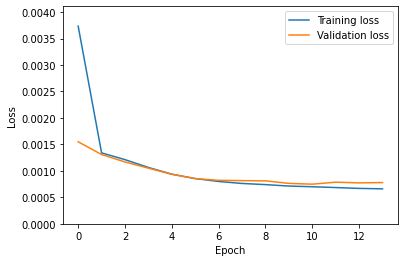

In [ ]:
import shutil
# Вызовы построения и тренировки нейросети
if mode in ('beta','class'):
  n_max, nhyp = get_sim_pars(hdfilename.replace('edf','idf'))
  datadir_Model = datadir + os.sep + 'Model'
  datadir_Graph = datadir + os.sep + 'Graph'
  checkpoint_path = datadir_Model + os.sep + f'{mode}_noise{noisefreqpersqmm:.0f}_tcor_weights.ckpt'
  model_path = datadir_Model + os.sep + f'{mode}_noise{noisefreqpersqmm:.0f}_tcor_model'

  nndata_dtypes, nndata_shapes = get_nndata_format(nndatafilename)

  model = None
  if restoreModel:
    try:
      print(f'Restoring model from path {model_path}...')
      with strategy.scope():
        model = tf.keras.models.load_model(model_path)
      assert(model.inputs[0].shape[1] == nndata_shapes[0][0])
    except:
      print('Failed to restore saved model!')
      if not fitModel:
        raise ValueError('Can not use unitialized model for prediciton!')
  if model is None:
    model = build_model(nndata_shapes[0], mode, hlayers, nhyp=nhyp)
  model.summary()

  print(f'Reading test data&labels from {nndatafilename}...')
  test_data = pd.read_hdf(nndatafilename, 'test_data')
  test_labels = pd.read_hdf(nndatafilename, 'test_labels')

  if fitModel:
    stopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3, restore_best_weights=True)
    tbCallback = tf.keras.callbacks.TensorBoard(log_dir=datadir_Graph, histogram_freq=1, write_graph=True, write_images=False)
    cpCallback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    monitor="val_loss",
                                                    save_weights_only=True,
                                                    verbose=0)

    train_data = pd.read_hdf(nndatafilename, 'train_data').to_numpy()
    train_labels = pd.read_hdf(nndatafilename, 'train_labels').to_numpy()

    bufferSize = train_data.shape[0]
    trainStepsPerEpoch = train_data.shape[0]//batchSize
    testStepsPerEpoch = test_data.shape[0]//batchSize

    if mode=='beta':
      train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels, train_labels)).shuffle(bufferSize).repeat().batch(batchSize, True)
      test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels, test_labels)).repeat().batch(batchSize, True)
    else:
      train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(bufferSize).repeat().batch(batchSize, True)
      test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).repeat().batch(batchSize, True)

    del train_data, train_labels

    #print(f'Train data size: {train_rows} events, validate/test data size: {test_rows} events')

    print(f'Fitting model for at maximum {maxepochs} epochs...')
    history = model.fit(train_dataset, epochs=maxepochs,
                        validation_data=test_dataset,
                        callbacks=[stopCallback, tbCallback, cpCallback],
                        steps_per_epoch=trainStepsPerEpoch,
                        validation_steps=testStepsPerEpoch)

    last_epoch = len(history.history['loss'])
    print("Last epoch number:", last_epoch)
    model.save(model_path)

    #if oncolab:
    #  !killall tensorboard  
    #%tensorboard --logdir "$datadir_Graph" --reload_multifile True

    plt.plot(history.history['loss'], '-', label='Training loss')
    plt.plot(history.history['val_loss'], '-', label='Validation loss')
    ymax = 1.1*max(*history.history['loss'],*history.history['val_loss'])
    plt.ylim(0, ymax)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
  

In [ ]:
import pandas as pd
filename = f'/mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_tcor_edf.h5'

chunk = 1
nevents = nhits = 0
for df in pd.read_hdf(filename, 'edf', chunksize=2000000):
  print(f'Chunk {chunk}')
  print(df.index.get_level_values('entry'))
  print(df.index.levels[0])
  nhits += df.index.get_level_values('entry').size
  nevents += df.index.levels[0].size
  chunk += 1
print(f'Total hits: {nhits}, total events: {nevents}')

Evaluate model on 264037 events
8252/8252 - 11s - loss: 0.0019 - mse: 0.0019
Evaluation took 11.03 seconds
Prediction took 5.83 seconds
Systematic shift of beta w.r.t. MC truth: 0.000249
Standard deviation of beta residuals: 0.00204
Minimum standard deviation among theta_p-beta bins: 0.0009004364128270484


/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:879: LogWarning: x is really small return 0
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:879: LogWarning: x is really small return 0
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:879: LogWarning: x is really small return 0
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:879: LogWarning: x is really small return 0
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:879: LogWarning: x is really small return 0
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:879: LogWarning: x is really small return 0
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:879: LogWarning: x is really small return 0
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:879: LogWarning: x is really small return 0
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:879: LogWarning: x is really small return 0
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:879: LogWarnin

Minimum fitted gaussian sigma among theta_p-beta bins: 0.0007626479211285433


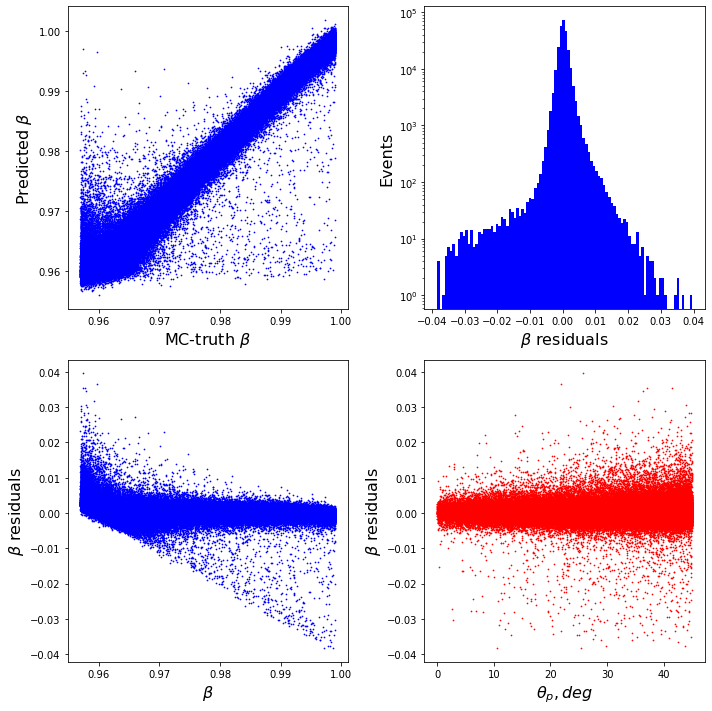

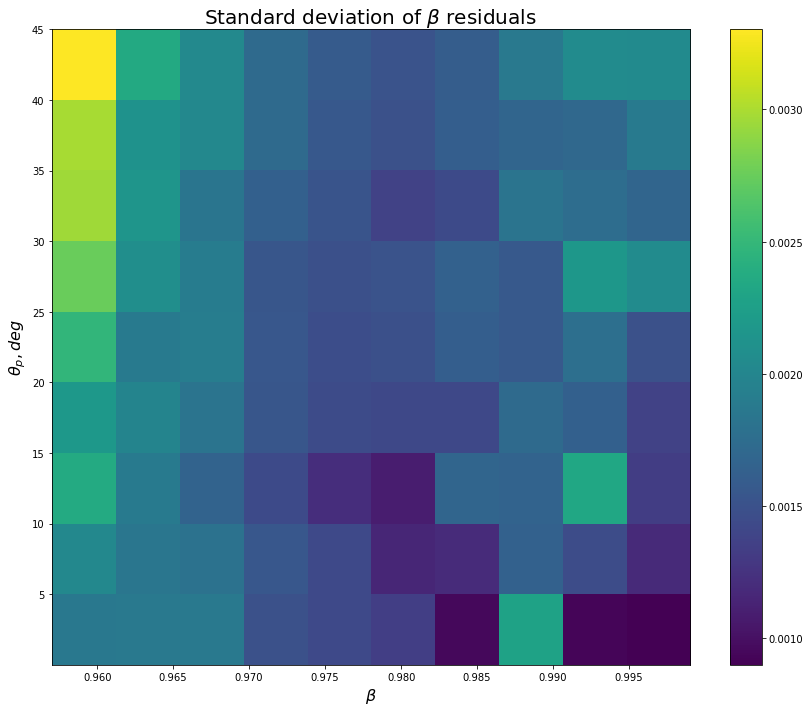

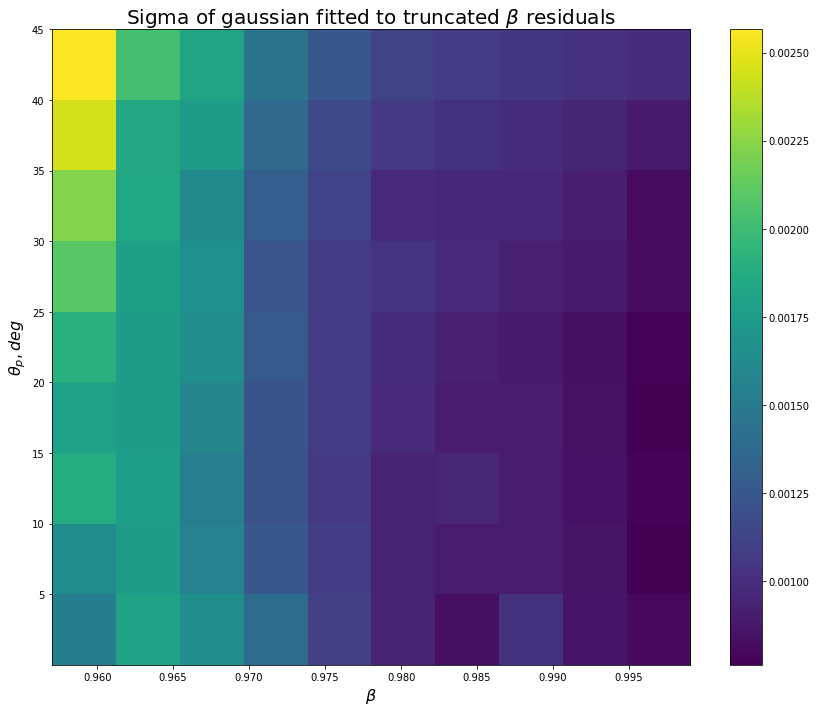

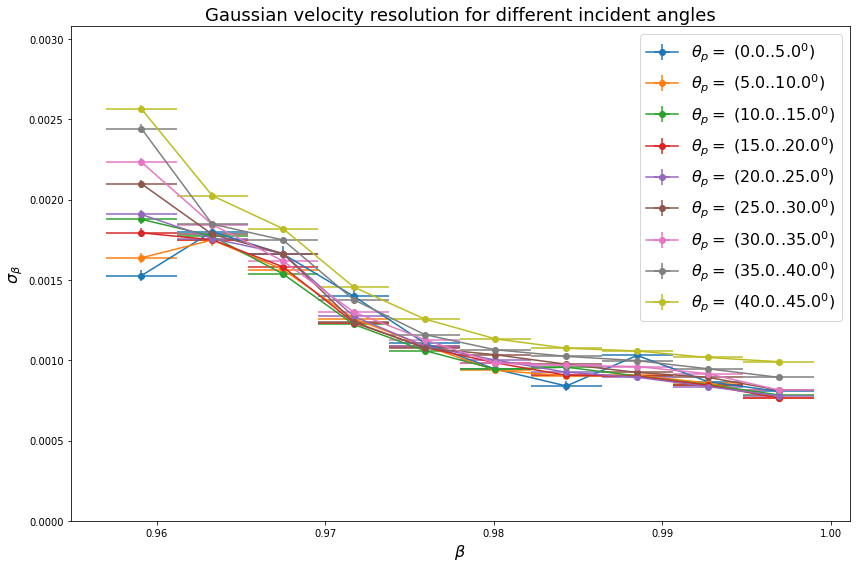

In [ ]:
# Функция преобразования выходных значений нейросети в скорость
def feature_to_beta(feature):
  return 1/n_max + (1-1/n_max) * feature

# Оценка работы нейросети на проверочных данных
metric, prediction = evaluate_model(test_data, test_labels, model, mode, feature_to_beta, datadir, True)

In [ ]:
from probfit.functor import Extended
def shape(x, N, mean, sigma, c):
  return N * gaussian(x, mean, sigma) + c

def evalSigmaBeta(nndatafilename, model_path, nbetapnts=10, theta_min=0, theta_max=10, draw=False):
  print(f'Reading test data from {nndatafilename}...')
  test_data = pd.read_hdf(nndatafilename, 'test_data')
  test_labels = pd.read_hdf(nndatafilename, 'test_labels')

  with strategy.scope():
    print(f'Restoring model from path {model_path}...')
    model = tf.keras.models.load_model(model_path)
    print(f'Predicting beta values...')
    prediction = model.predict(test_data).flatten()

  # Break up data into bins on beta and theta
  betas = 1/n_max + (1-1/n_max) * test_labels
  beta_residual = (1-1/n_max) * (prediction-test_labels)
  thetas = test_data['theta_p_norm']*90 # градусы
  beta_min, beta_max = betas.min(), betas.max()+1e-5
  theta_mask = (thetas>=theta_min) & (thetas<theta_max)
  betas, beta_residual = betas[theta_mask], beta_residual[theta_mask]
  beta_pnt = beta_min + (beta_max-beta_min) * (np.floor(nbetapnts * (betas-beta_min) / (beta_max-beta_min)) + 0.5) / nbetapnts
  resdfgrp = pd.DataFrame({'beta_pnt': beta_pnt, 'residual': beta_residual}, dtype=np.float64).groupby('beta_pnt')

  beta_set = np.zeros(nbetapnts)
  sigbeta = np.zeros(nbetapnts)
  sigbeta_error = np.zeros(nbetapnts)

  if draw:
    plt.figure(figsize=(12,nbetapnts*3))
  isp = 0
  for b, data in resdfgrp:
    series = data['residual']
    mean, sd = series.mean(), series.std()
    q1, q2 = mean-3*sd, mean+3*sd
    cutseries = series[(q1<series)&(series<q2)]

    blh = BinnedLH(shape, cutseries, bins=100, bound=(q1,q2))
    m = Minuit(blh, N=1, mean=cutseries.mean(), sigma=cutseries.std(), c=1, print_level=0)
    m.errordef = Minuit.LIKELIHOOD

    r = m.migrad() # fit

    #print(r)

    beta_set[isp] = b
    sigbeta[isp] = m.values['sigma']
    sigbeta_error[isp] = m.errors['sigma']

    if draw:
      plt.subplot((nbetapnts+1)//2, 2, isp+1)
      blh.draw(m)
      plt.semilogy()
      plt.title(fr'$\beta$={beta_set[isp]:6.4f}')
      plt.tight_layout()
    isp += 1

  return beta_set, sigbeta, sigbeta_error

Reading test data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_nndata.h5...
Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_noise50000_model...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is re

Reading test data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_tcor_nndata.h5...
Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_noise50000_tcor_model...
Predicting beta values...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is re

Reading test data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_noise50000_notiming_nndata.h5...
Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_noise50000_notiming_model...
Predicting beta values...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: LogWarning: x is re

<Figure size 720x720 with 0 Axes>

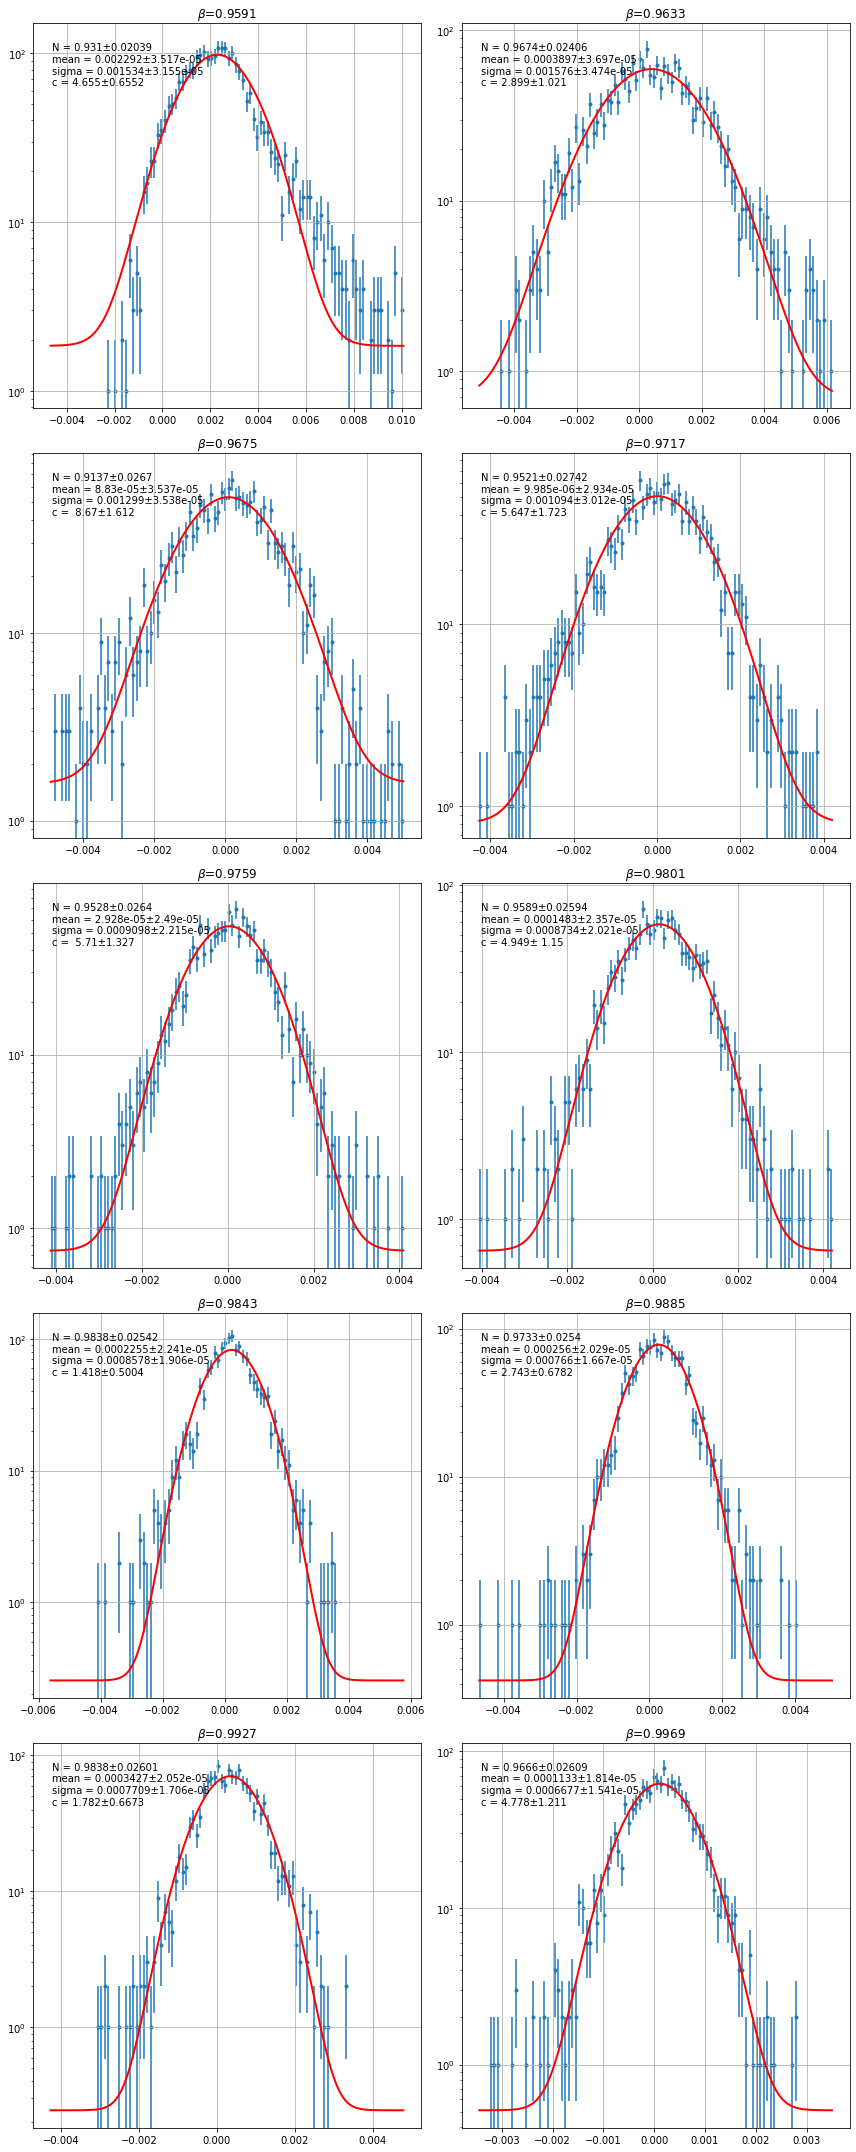

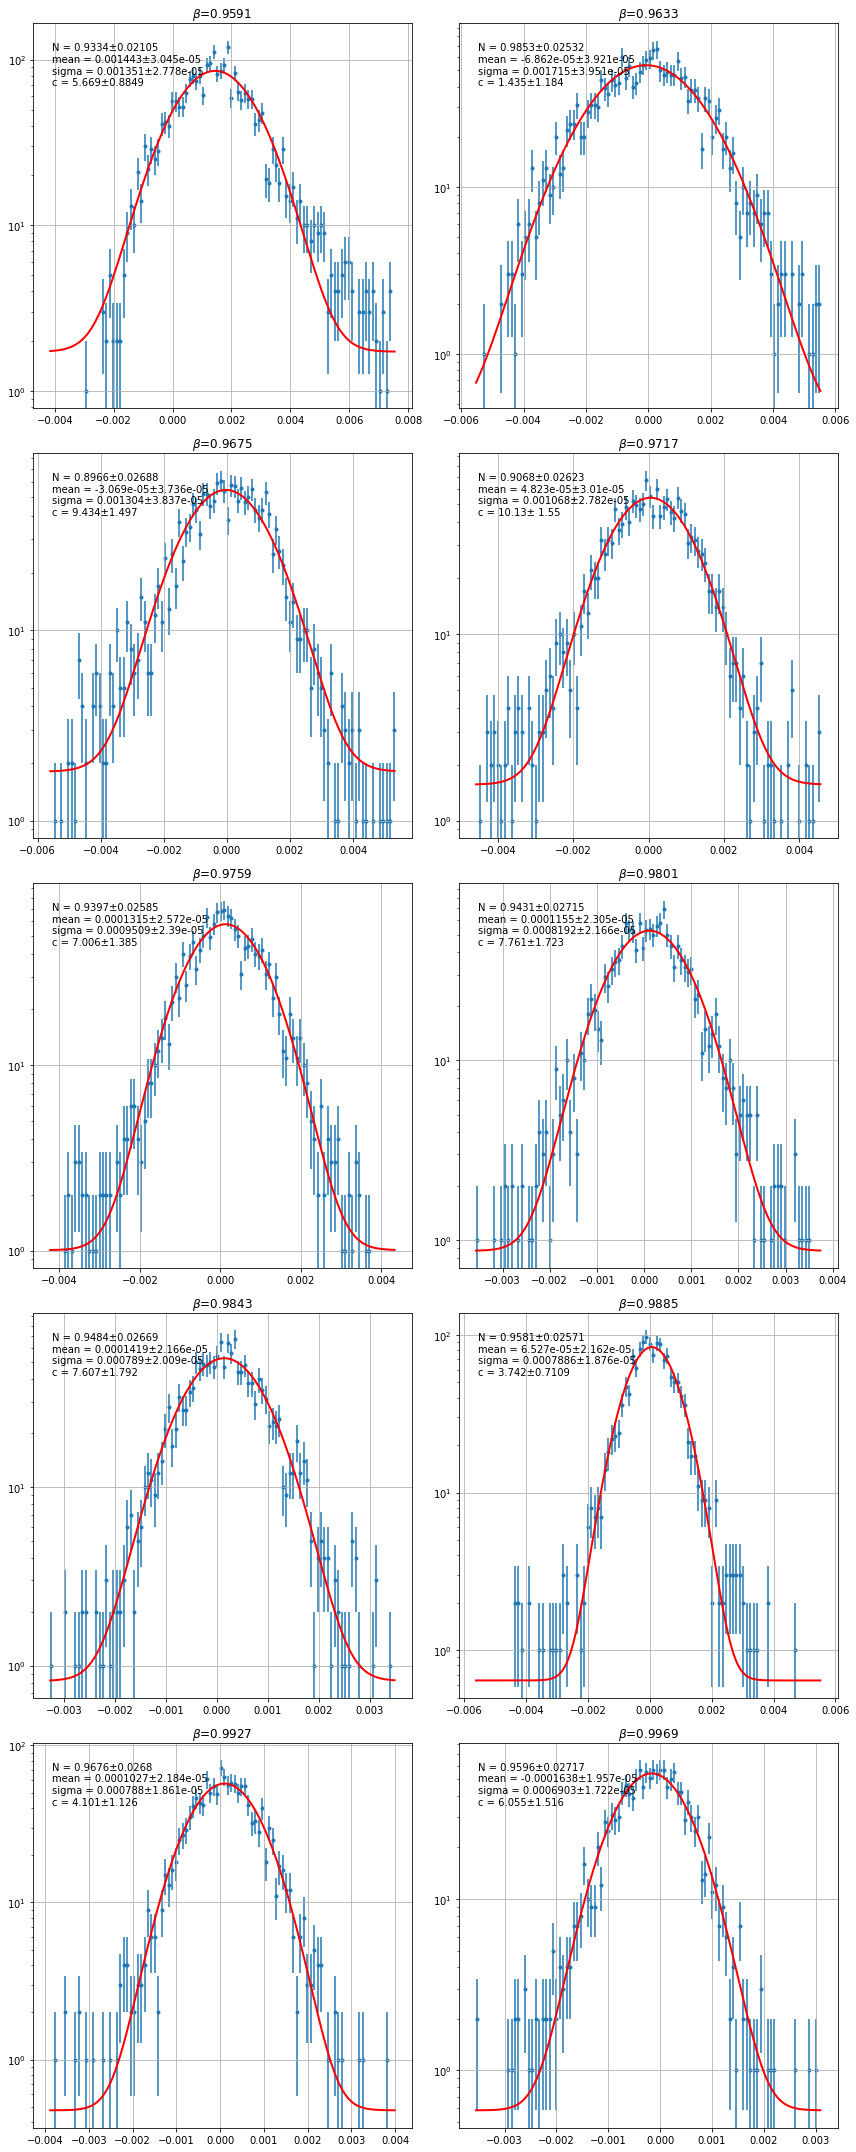

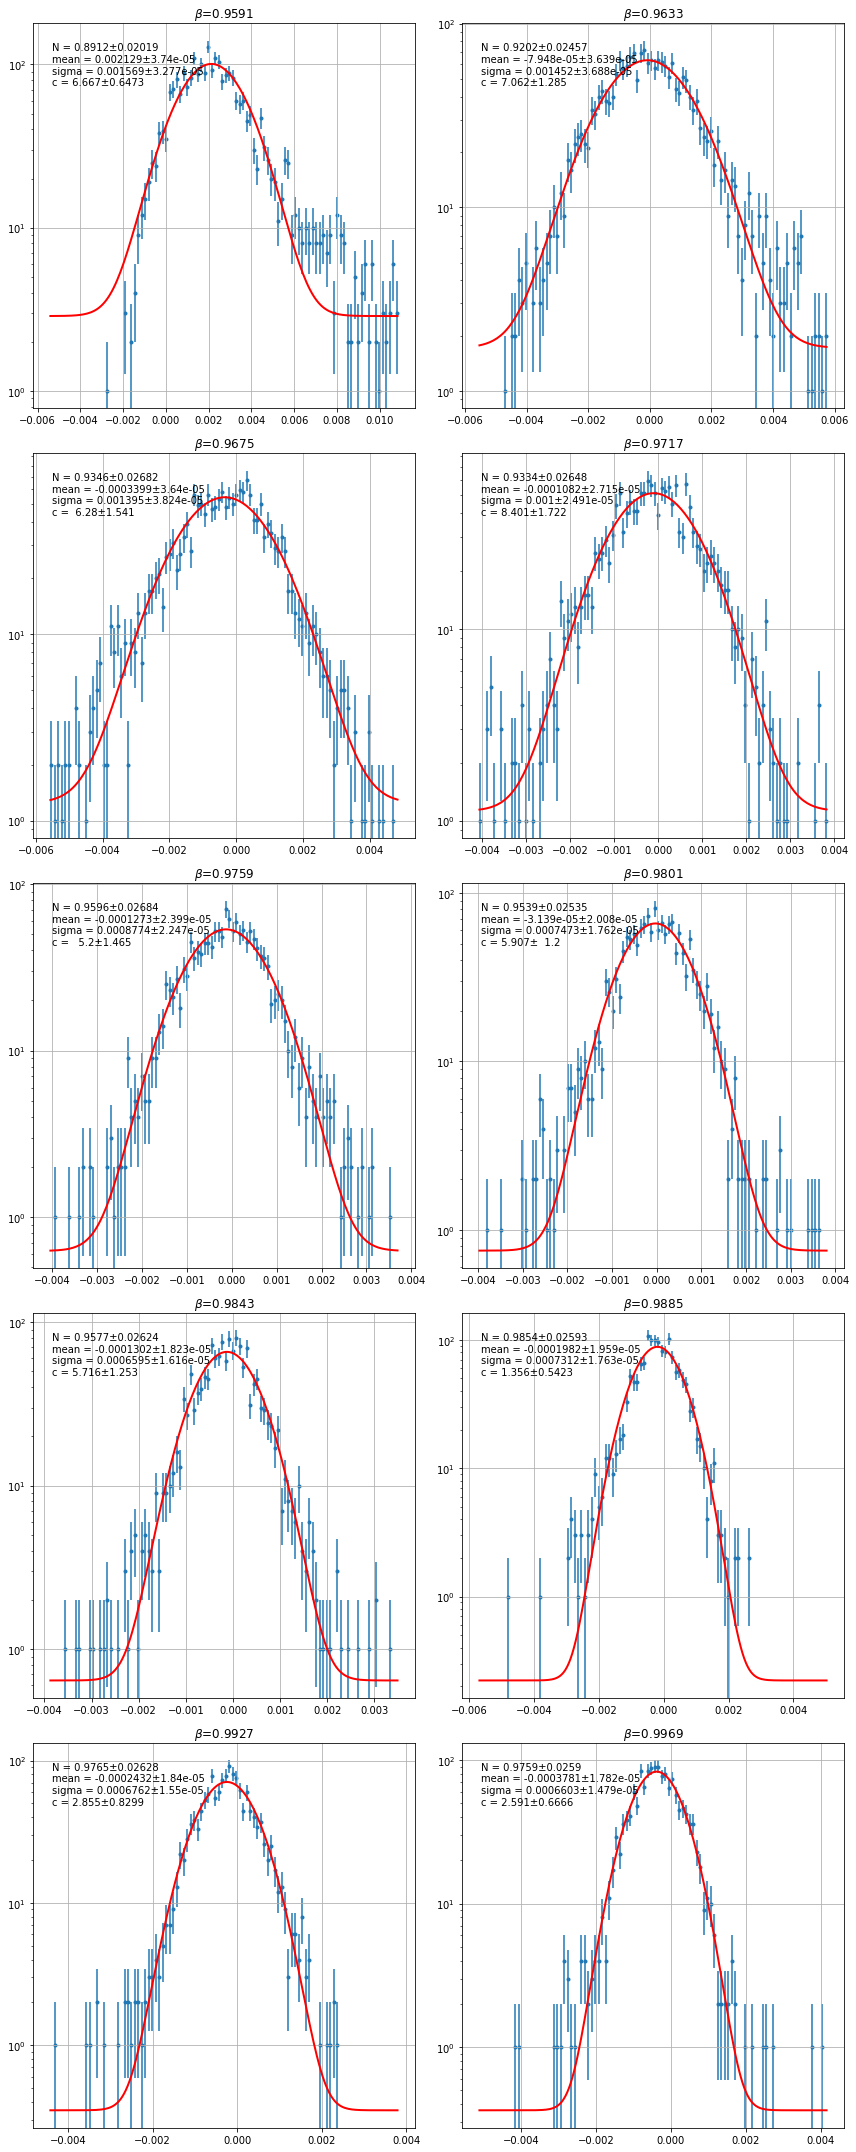

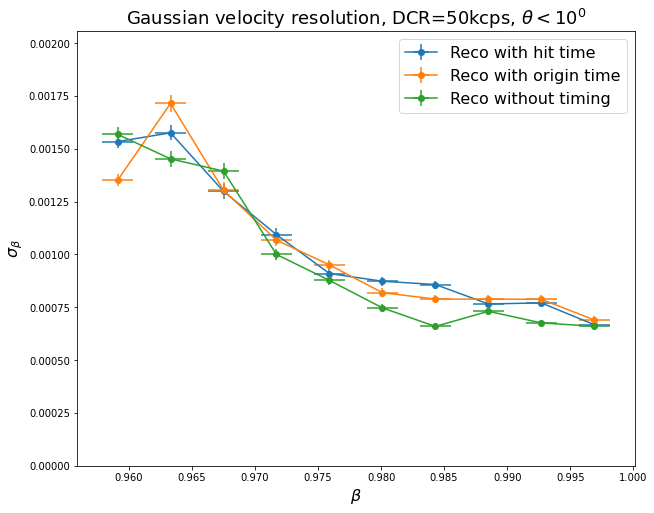

In [ ]:
nbetapnts = 10
suffixes = ('', '_tcor', '_notiming')
labels = ('Reco with hit time', 'Reco with origin time', 'Reco without timing')
nplots = len(suffixes)
betas = np.zeros((nbetapnts, nplots))
sigbetas = np.zeros((nbetapnts, nplots))
sigbeta_errors = np.zeros((nbetapnts, nplots))

noisefreqpersqmm = 50000
fig = plt.figure(figsize=(10,10))
for i in range(nplots):
  nndatafilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}' + suffixes[i] + '_nndata.h5'
  model_path = datadir + os.sep + 'Model' + os.sep + f'{mode}_noise{noisefreqpersqmm}' + suffixes[i] + '_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, nbetapnts, theta_min=0, theta_max=10, draw=True)

plt.figure(figsize=(10,8))
for i in range(nplots):
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, DCR={noisefreqpersqmm/1e3:.0f}kcps, $\theta<10^0$', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.legend(fontsize=16)
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta0-10deg_dcr{noisefreqpersqmm/1e3:.0f}kcps_recotimeoptions.png')